In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

# TP1

In [4]:
df_original = pd.read_csv("train.csv", dtype={
    'tipodepropiedad':'category', 'ciudad':'category',\
    'provincia':'category', 'gimnasio':'bool', 'usosmultiples':'bool',\
    'piscina':'bool', 'escuelascercanas':'bool',\
    'centroscomercialescercanos':'bool' }, parse_dates=[16])

In [5]:
# Renombramos convenientemente algunas columnas
df_original = df_original.rename(columns={'tipodepropiedad':'tipo', 'habitaciones':'cant_habitaciones', 'garages':'cant_garages', 'banos':'cant_banios',
       'lat':'latitud', 'lng':'longitud'})

In [6]:
df_original.columns

Index(['id', 'titulo', 'descripcion', 'tipo', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'cant_habitaciones', 'cant_garages',
       'cant_banios', 'metroscubiertos', 'metrostotales', 'idzona', 'latitud',
       'longitud', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio'],
      dtype='object')

In [7]:
# Identificamos para cada columna qué porcentaje de los datos de cada columna son nulos 

porcentajes = df_original.isna().sum()/len(df_original.index)

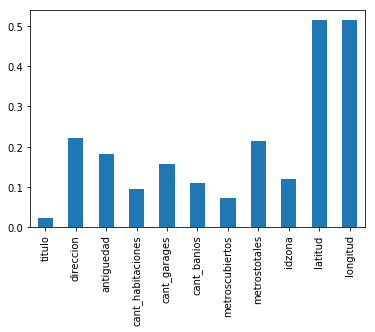

In [8]:
porcentajes_mayores_1 = porcentajes[porcentajes >= 0.01]
porcentajes_mayores_1.plot(kind='bar')

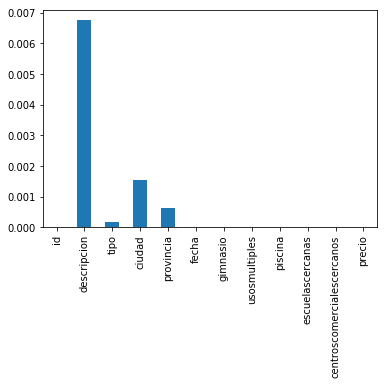

In [9]:
porcentajes_menores_1 = porcentajes[porcentajes < 0.01]
porcentajes_menores_1.plot(kind='bar')

In [10]:
df_original['anio'] = df_original['fecha'].dt.year

In [11]:
df_original['mes'] = df_original['fecha'].dt.month

In [12]:
df_original.anio

0         2015
1         2013
2         2015
3         2012
4         2016
          ... 
239995    2015
239996    2014
239997    2015
239998    2014
239999    2015
Name: anio, Length: 240000, dtype: int64

In [13]:
df_original.mes

0          8
1          6
2         10
3          3
4          6
          ..
239995     2
239996     7
239997     3
239998    12
239999     6
Name: mes, Length: 240000, dtype: int64

Comparar el siguiente gráfico con la inflación en Mexico
[https://www.focus-economics.com/country-indicator/mexico/inflation]
[https://www.inflation.eu/inflation-rates/mexico/historic-inflation/cpi-inflation-mexico.aspx]
[https://www.globalpropertyguide.com/Latin-America/mexico/Price-History]

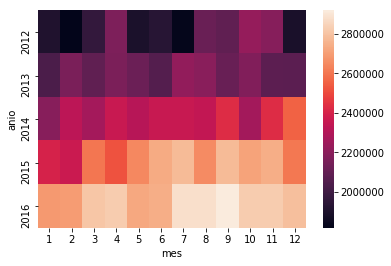

In [14]:
mes_x_anio = df_original.pivot_table(index='anio', columns='mes', values='precio', aggfunc='mean')
g = sns.heatmap(mes_x_anio)

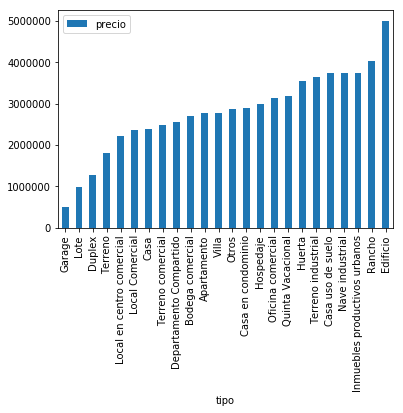

In [15]:
# Precio promedio por tipo
df_original.plot()
df_original.dropna(axis=0, subset=['tipo'])\
    .groupby('tipo').agg({'precio':'mean'})\
    .sort_values('precio').plot(kind='bar') 

Text(0.5, 1.0, 'Cantidad total de propiedades')

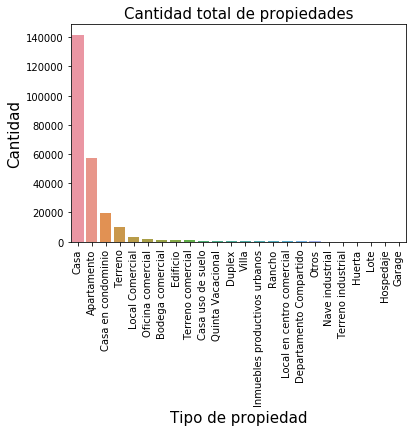

In [16]:
g = sns.countplot(x='tipo', data=df_original, order=df_original['tipo'].value_counts().index, orient='v')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Tipo de propiedad", fontsize=15)
g.set_ylabel("Cantidad", fontsize=15)
g.set_title("Cantidad total de propiedades", fontsize=15)

# boludeo


In [7]:
def func(a):
    a = str(a)
    return len(a.split(' '))
df_original['cant_palabras_descripcion'] = df_original['descripcion'].apply(func)


In [8]:
df_original['precio'].mean()

2530838.3458958333

In [9]:
asdf = df_original.groupby(pd.cut(df_original['precio'], 1000)).agg({'cant_palabras_descripcion':'mean'})

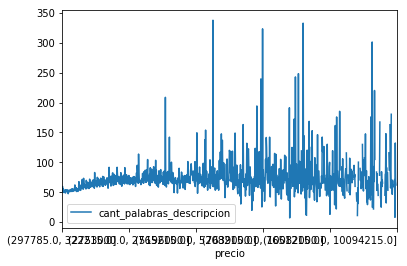

In [10]:
asdf.plot(kind='line')

In [ ]:
np.arange(0, 239999, 239999/50)